# Fast Fourier Tansform Scratch

Implementation of Fast Fourier Transform  Cooley and Turkey algorithm using python

- Base link [FFT](https://www.youtube.com/watch?v=m53dNOpHmbg)

In [2]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import time
from cmath import exp, pi

THe Fast Fourier Transform (FFT) is a divide and conquer algorithm that recursively splits the input array into two parts: one for the odd indices, and another for the even indices, until the trivial case is achieved.

It is important to note that complex exponentials (That can be decomposed into a sum of sine and cosine) are periodic and symmetric, and from those properties the FFT is defined.

In particular, from $e^{-j\frac{2*\pi}{N}xu}$, we isolate the constant term, and define it as a variable:

${W} = e^{-j\frac{2*\pi}{N}}$. Note ${W}$ is constant because it does not depend on the time sampling (controlled by $x$), nor depends on the frequencies ($u$)

For example, for a signal with 4 observations, i.e. $N=4$

In [3]:
N = 4
W = exp(-1j*(2*pi)/N)
print(W)

(6.123233995736766e-17-1j)


this value does not depend on $u$ nor $x$. The two properties we are going to use to implement the FFT are:

1. Periodicity in u,x: $W_{N}^{ux}=W_{N}^{u(N+x)}=W_{N}^{(u+N)x}$
2. Symmetry of the complex conjugate: $W_{N}^{u(N-x)}=W_{N}^{-ux}=(W_{N}^{ux})*$ for example this is easy to see for $x=N$, $W_{N}^{uN}=e^{-j2\pi N} = 1$

Now we define the \textbf{division} step of the algorithm. This is done by decomposing the transform into even and odd indices of $x$. To avoid a cluttered notation, let us express the transform in terms of the variable $W$:

$F(u) = \sum_{x=0}^{N-1}{f(x)W_{N}^{ux}}$

Now we write the function of evaluating the even indices $2x$ and the odd indices $2x+1$:

$F(u) = \sum_{x=0}^{N/2-1}{f(2x)W_{N}^{u2x}} + \sum_{x=0}^{N/2-1}{f(2x+1)W_{N}^{u(2x+1)}}$

Note $2x$ forms the sequence $0, 2, 4, 6,$ while $2x+1$ the sequence $1, 3, 5, 7$ as we wanted, therefore:

$F(u) = \sum_{x=0}^{N/2-1}{f(2x)\cdot(W_{N}^{2})^{ux}} + \sum_{x=0}^{N/2-1}{f(2x+1)\cdot(W_{N}^{2})^{(2x+1)u}}$

Let us manipultate this sum, isolating the terms that are independent of $x$, which is the $W_{N}^{u}$

$F(u) = \sum_{x=0}^{N/2-1}{f(2x)\cdot(W_{N}^{2})^{ux}} + W_{N}^{u}\cdot\sum_{x=0}^{N/2-1}{f(2x+1)\cdot(W_{N}^{2})^{ux}}$

But we note that $W_{N}^{2} = e^{-j\frac{2\pi}{N}2} = e^{-j\frac{2\pi}{N/2}} = W_{N/2}$

and this is defines the 'trick', since it allows to write the transform as:

$F(u) = \sum_{x=0}^{N/2-1}{f(2x)\cdot W_{N/2}^{ux}} + W_{N}^{u}\cdot\sum_{x=0}^{N/2-1}{f(2x+1)\cdot W_{N/2}^{ux}}$

The first term is the DFT of the $N/2$ elements corresponding to the even indices, the second term is the DFT of the $N/2$ elements related to the odd indices.

This way, we can split the DFT of $N$ elements, in a recursive way, into two $N/2$ DFTs, and later combine the results:

$F(u) = F_{even}(u)+W_{N}^{u}\cdot F_{odd}(u)$

Recall the property of symmetry of the complex conjugate:

$F(u + N/2) = F_{even}(u)-W_{N}^{u}\cdot F_{odd}(u)$

In [7]:
# Let us try to grasp this idea for a small example
N = 4
f = [0, 100, 200, 300]
f

[0, 100, 200, 300]

In [8]:
# splitting the array into even and odd indices
f_even = f[0::2]
f_odd  = f[1::2]
print(f_even)
print(f_odd)

[0, 200]
[100, 300]


In [9]:
# Recursively, we split the reeuslting arrays, first the even, into even and odd
f_even_even = f_even[0::2]
f_even_odd  = f_even[1::2]
print(f_even_even)
print(f_even_odd)

[0]
[200]


In this example, we partition the elements until we reach the base case, that is when there is only 1 even and 1 odd element, allowing to compute:

In [10]:
reseven0 = f_even_even[0] + exp(-2j*pi*0/N) * f_even_odd[0]
reseven1 = f_even_even[0] - exp(-2j*pi*0/N) * f_even_odd[0]
reseven = [reseven0, reseven1]
print(reseven)

[(200+0j), (-200+0j)]


Now this result is stored and we execute the other 'side' of the recursion, relative to the first odd indices

In [11]:
# separate the odd indices, into even and odd indices
f_odd_even = f_odd[0::2]
f_odd_odd  = f_odd[1::2]
print(f_odd_even)
print(f_odd_odd)

[100]
[300]


In [12]:
resodd0 = f_odd_even[0] + exp(-2j*pi*0/N) * f_odd_odd[0]
resodd1 = f_odd_even[0] - exp(-2j*pi*0/N) * f_odd_odd[0]
resodd = [resodd0, resodd1]
print(resodd)

[(400+0j), (-200+0j)]


Now combining the individual results (reseven and resodd):

In [13]:
# from the symmetruc property, I can use the result 0 to also obtain the value for 0+N/2 = N/4 = 2, changing the signal
res0 = reseven[0] + exp(-2j*pi*0/N) * resodd[0]
res2 = reseven[0] - exp(-2j*pi*0/N) * resodd[0]

# Similarly the result 1 is used to obain the result of 1+N/2 = 1+N/4 = 3
res1 = reseven[1] + exp(-2j*pi*1/N) * resodd[1]
res3 = reseven[1] - exp(-2j*pi*1/N) * resodd[1]

# putting everything together
F_manual = np.array([res0, res1, res2, res3]).astype(np.complex64)
print(F_manual)

[ 600.  +0.j -200.+200.j -200.  +0.j -200.-200.j]


### Test with scipy fft

In [16]:
from scipy.fft import fft, ifft
x = np.array([0, 100, 200, 300])
y = fft(x)
print(y)
# res = ifft(y)
# print(res)

[ 600.  -0.j -200.+200.j -200.  -0.j -200.-200.j]


## Algorithm

Let us code a function for this algorithm

### improvement for the future

it is necesary that consider to increment the size of the array until a power of 2 value to improve the result (2**n)

In [18]:
def FFT(f): 
    N = len(f)
    if N <= 1:
        return f

    # division
    even = FFT(f[0::2])
    odd  = FFT(f[1::2])

    # store the combination of results
    temp = np.zeros(N).astype(np.complex64)

    # only required to compute for half the frequencies
    # since u+N/2 can be obtained from the symmetriy property
    for u in range(N//2):
        temp[u] = even[u] + exp(-2j*pi*u/N) * odd[u] #conquer
        temp[u+N//2] = even[u] - exp(-2j*pi*u/N) * odd[u] #conquer

    return temp

In [19]:
# testing the funtion to see if it matches the manual computation
F_fft = FFT(f)
print(F_fft)

[ 600.  +0.j -200.+200.j -200.  +0.j -200.-200.j]


Let us comparte with DFT1D

In [20]:
def DFT1D(f):
    #create empty array of complex coefficients
    F = np.zeros(f.shape, dtype=np.complex64)
    n = f.shape[0]

    # Creating indices for x, allowing to compute the multiplication
    x = np.arange(n)
    # for each frequency 'u', perform vectorial multiplication
    for u in np.arange(n):
        F[u] = np.sum(f*np.exp((-1j * 2 * np.pi * u*x) / n))
    return F

In [21]:
F_dft = DFT1D(np.array(f))
print(F_dft)

[ 600.+0.000000e+00j -200.+2.000000e+02j -200.-7.347881e-14j
 -200.-2.000000e+02j]


In [22]:
print(F_manual)
print(F_fft)
print(F_dft)


[ 600.  +0.j -200.+200.j -200.  +0.j -200.-200.j]
[ 600.  +0.j -200.+200.j -200.  +0.j -200.-200.j]
[ 600.+0.000000e+00j -200.+2.000000e+02j -200.-7.347881e-14j
 -200.-2.000000e+02j]


Due to the approximation, sometimes a small error is observed between the results

### Performance time compare

(16384,)


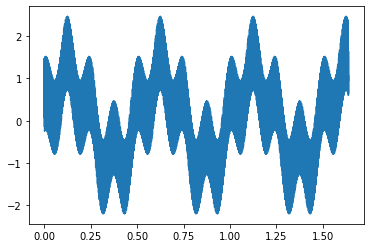

In [63]:
Fs = 10000
L= 2**14
t = np.arange(0, (L)/Fs, 1/Fs)
f_in = 1*np.sin(t*(2*np.pi)*2) + 0.6*np.cos(t*(2*np.pi)*8) + 0.4*np.cos(t*(2*np.pi)*200) + 0.5*np.sin(t*(2*np.pi)*2000)
freq = Fs*np.arange(0,(L/2))/L
print(f_in.shape)

plt.plot(t,f_in)

Using scipy fft

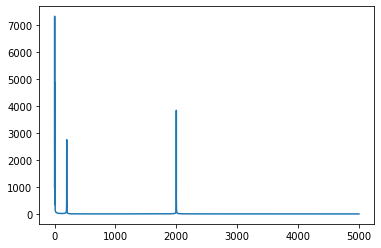

In [66]:
y_fft = fft(f_in)

plt.plot(freq,np.abs(y_fft)[0:int(L/2)])

Using def FFT

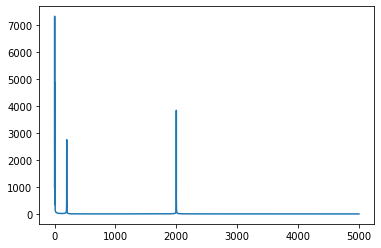

In [67]:
y_FFT = FFT(f_in) # it works well if N = 2**n value

plt.plot(freq,np.abs(y_FFT)[0:int(L/2)])

Using DFT1d

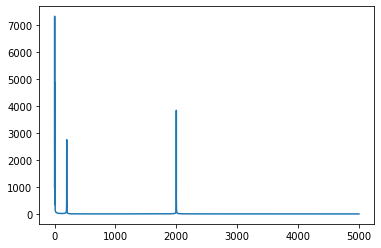

In [68]:
y_dft = DFT1D(f_in)

plt.plot(freq,np.abs(y_dft)[0:int(L/2)])

In [62]:
import timeit # to measure the performance of the execution

print('scipy FFT (s):')
cpu_time = timeit.timeit('fft(f_in)', number=5, setup="from __main__ import fft, f_in")
print(cpu_time/5)

print('def FFT (s):')
cpu_time = timeit.timeit('FFT(f_in)', number=5, setup="from __main__ import FFT, f_in")
print(cpu_time/5)

print('DFT1d (s):')
cpu_time = timeit.timeit('DFT1D(f_in)', number=1, setup="from __main__ import DFT1D, f_in")
print(cpu_time/1)

scipy FFT (s):
0.00038256000261753796
def FFT (s):
0.7122551799984649
DFT1d (s):
18.189015100011602
